<a href="https://colab.research.google.com/github/Metode-de-inspiratie-biologica-2021/lab-11-jafetimbre/blob/main/lab11referat_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducere

În acest studiu se vor analiza două metode de optimizare peste problema rezolvării unui puzzle **SUDOKU**.









## Descrierea problemei/jocului

Jocul sudoku este un joc în formă de grilă având ca scop umplerea aceasteia cu cifrele de la 1 la 9 respectând anumite condiții, cu unele cifre fiind de la început dispuse în grilă.

Grila jocului este un pătrat de nouă pe nouă căsuțe, subdivizat în tot atâtea pătrate identice, numite regiuni, după cum se observă în imaginea aferentă:

<img src="https://raw.githubusercontent.com/jafetimbre/fantastic-sudoku-solver/master/img/init_config_1.png" width="400" >

Fig. 1. Exemplificarea unei grile de sudoku [Sursa imaginii](https://raw.githubusercontent.com/jafetimbre/fantastic-sudoku-solver/master/img/init_config_1.png)

Regula jocului este simplă: fiecare rând, coloană sau regiune nu trebuie să conțină decât o dată cifrele de la unu la nouă. Formulat altfel, fiecare ansamblu trebuie să conțină cifrele de la unu la nouă o singură dată.


## Obiectul studiului

Acvest studiu își propune compararea modalității de rezolvare a problemei dintre un algoritm evolutiv și un algoritm bazat pe Hill Climbing.

# Implementare generală

Instalarea librăriilor, cu ajutorul comenzii `pip install`:

In [1]:
!pip install deap -q

Importarea componentelor și librăriilor principale:

In [2]:
import random
import numpy as np
import sys
import matplotlib.pyplot as plt
from deap import creator, base, tools, algorithms
import seaborn as sns

Definirea configurației inițiale al jocului de sudoku unde avem triplete de valori `(valoare, linie, coloană)`.

In [3]:
BOARD_CONFIG = np.array([
    (7, 0, 1),
    (8, 0, 5),
    (1, 0, 6),
    (9, 0, 7),
    (3, 1, 1),
    (9, 1, 4),
    (6, 1, 5),
    (5, 1, 6),
    (4, 2, 0),
    (1, 2, 3),
    (2, 2, 5),
    (8, 2, 6),
    (6, 4, 4),
    (4, 4, 5),
    (2, 4, 6),
    (1, 4, 7),
    (3, 4, 8),
    (2, 5, 1),
    (4, 5, 6),
    (4, 6, 1),
    (7, 6, 2),
    (5, 6, 3),
    (3, 6, 4),
    (6, 6, 6),
    (8, 6, 7),
    (2, 6, 8),
    (8, 7, 0),
    (5, 7, 1),
    (3, 7, 2),
    (6, 7, 3),
    (7, 7, 5),
    (9, 7, 6),
    (4, 7, 7),
    (6, 8, 1),
    (1, 8, 2),
    (8, 8, 3),
    (4, 8, 4),
    (5, 8, 8)
])

Astfel, punctul de pornire al problemei va arăta astfel:

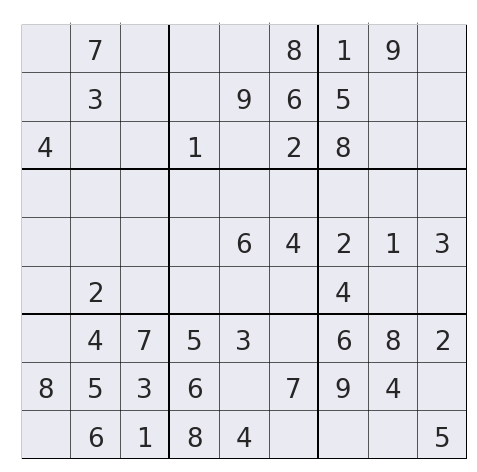

In [4]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)

maj_t = np.arange(0, 10, 3)
min_t = np.arange(0, 10, 1)

ax.set_xticks(maj_t)
ax.set_xticks(min_t, minor=True)
ax.xaxis.tick_top()

ax.set_yticks(maj_t)
ax.set_yticks(min_t, minor=True)  
ax.invert_yaxis()

ax.tick_params(axis='both', colors='white') 
ax.grid(which='minor', alpha=0.8, color='black')
ax.grid(which='major', alpha=1, linewidth=2, color='black')

for val, row, col in BOARD_CONFIG:
    ax.text(col+.5, row+.6, val, verticalalignment='center', horizontalalignment='center', fontsize=26)

plt.show()

De sigur, după cum se observă, nu este o configurație foarte dificilă de rezolvat, dar pentru a putea compara cele două metode este suficient de complex.

Prima metodă construită a fost metoda de afișare a unei configurații. Acesta se folosește de metodele de desenare din librăria [Matplotlib](https://matplotlib.org/).

In [5]:
def draw_board(board_state):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1, 1, 1)

    maj_t = np.arange(0, 10, 3)
    min_t = np.arange(0, 10, 1)

    ax.set_xticks(maj_t)
    ax.set_xticks(min_t, minor=True)
    ax.xaxis.tick_top()
    
    ax.set_yticks(maj_t)
    ax.set_yticks(min_t, minor=True)  
    ax.invert_yaxis()

    ax.tick_params(axis='both', colors='white') 
    ax.grid(which='minor', alpha=0.8, color='black')
    ax.grid(which='major', alpha=1, linewidth=2, color='black')

    board_conf_cords = list(zip(BOARD_CONFIG.T[1], BOARD_CONFIG.T[2]))

    for i in range(len(board_state)):
        for j in range(len(board_state[i])):
            if (i, j) in board_conf_cords:
                ax.text(j+.5, i+.6, board_state[i][j], verticalalignment='center', horizontalalignment='center', fontsize=26)
            else:
                ax.text(j+.5, i+.6, board_state[i][j], verticalalignment='center', horizontalalignment='center', fontsize=26, color='grey')

    plt.show()

De sigur, algoritmul evolutiv nu va lucra cu matricea de stare a jocului, ci o formă mai simploficată de cromozom, astfel:

<img src="https://raw.githubusercontent.com/jafetimbre/fantastic-sudoku-solver/master/img/individ_repr.jpg" width="800">

Fig. 2. Modul de reprezentare a configurației în cromozomi [Sursa imaginii](https://raw.githubusercontent.com/jafetimbre/fantastic-sudoku-solver/master/img/individ_repr.jpg)

Pentru transformarea inversă (din individ/cromozom în grilă) a fost implementată următoarea funcție:



In [6]:
def individual_to_board(individual):
    flat_init_state_indx = list(map(lambda t: t[1]*9 + t[2], BOARD_CONFIG)) # pentru a intinde matricea initiala
    values = BOARD_CONFIG.T[0]
    flat_board = []
    init_values_count = 0

    for i in range(81):
        if (i in flat_init_state_indx):
            flat_board.append(values[init_values_count])
            init_values_count += 1
            continue
        flat_board.append(individual[i - init_values_count])
    return np.array(flat_board).reshape(9,9)

Această funcție este folosită ca funcție ajutătoare pentru a calcula fitnesul și pentru a afișa configurațiile.

In [7]:
def draw_board_from_ind(individual):
    board_from_ind = individual_to_board(individual)
    draw_board(board_from_ind)

In [8]:
def individual_fitness(individual):
    board_from_ind = individual_to_board(individual)
    return board_fitness(board_from_ind),

Pentru a calcula și a contoriza corectitudinea (fitness) a unei configurații, s-a creat funcția `board_fitness` care însumează numărul de valori unice dintre rânduri, coloane și sub grupuri. 

In [9]:
def board_fitness(board_state):
    fitness = 0
    nr_rows, nr_cols = board_state.shape

    # Verificarea liniilor si a coloanelor dupa elemente comune
    for row in board_state:
        fitness += len(np.unique(row))
    for col in board_state.T:
        fitness += len(np.unique(col))

    # Verificarea sub patratelor dupa elemente comune
    for i in range(0, 3):
        for j in range(0, 3):
            board_group = board_state[3*i:3*i+3, 3*j:3*j+3]
            fitness += len(np.unique(board_group))
    
    return fitness

O altă funcție importantă este `generate_random_individual` care generează configurații aleatoare folosind o configurația inițială constantă.

In [10]:
def generate_random_individual():
    board = (np.indices((9,9)) + 1)[1]

    for i in range(len(board)):
        board[i] = np.random.permutation(board[i])
    
    for (val, row, col) in BOARD_CONFIG:
        value_index = np.where(board[row]==val)[0][0]
        board[row][value_index], board[row][col] = board[row][col], board[row][value_index]

    fixed_values_mask = np.ones((9,9), dtype=bool)
    for (val, row, col) in BOARD_CONFIG:
        fixed_values_mask[row][col] = False

    return board[fixed_values_mask].tolist()

Valoarea fitnesului maxim este numărul total de valori unice calculate pe rând, coloană și subgrup, adică `81 + 81 + 81 = 243`

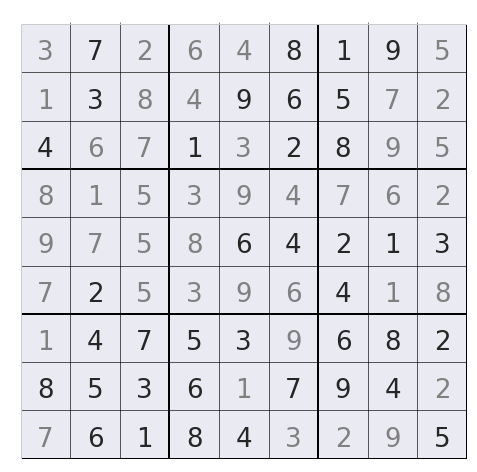


The fitness of the test individual is: 195/243


In [11]:
test_individual = generate_random_individual()
fintess_test_ind = individual_fitness(test_individual)

draw_board_from_ind(test_individual)
print(f'\nThe fitness of the test individual is: {fintess_test_ind[0]}/243')

# Metode

Se vor folosi doi algoritmi, unul Evolutiv Simplu, elitist și o metodă Hill Climber



## Algoritmul evolutiv simplu, elitist

Mai jos este implementat un algoritm evolutiv simplu, cu doua diferente minore:

- halloffame este folosit pentru a implementa un mecanism elitist. Indivizii din halloffame sunt automat copiati in urmatoarea generatie si nu sunt supuse operatorilor genetici de selectie, incrucisare si mutatie

- suport pentru o functie callback ce va fi apelata dupa fiecare iteratie a metodei. Functia callback va primii ca parametrii indexul generatiei curente si cea mai buna solutie gasita pana in prezent aceste functii callback sunt utile mai ales pentru logarea procesului de cautare

Funcția callback se poate folosi pentru a verifica soluțiile intermediare s-au pentru a salva acestea.

In [12]:
def ea_simple_elitist(population, toolbox, cxpb, mutpb, ngen, callback=None, stats=None, halloffame=None, verbose=__debug__):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        # versiune elitista
        raise ValueError("halloffame parameter must not be empty!")
    
    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    for gen in range(1, ngen + 1):
        # Selectam indivizii pentru generatia urmatoare 
        # (lasand loc pt. indivizii copiati in mod elitist: -hof_size)
        offspring = toolbox.select(population, len(population) - hof_size)
    
        # Aplicam operatorii de variatie
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluam fitnessul unde este necesar 
        # (s-a modificat cromozomul, fitnesul vechi a devenit invalid)
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        # mecanism elitist, copiem cei mai bunzi indivizi fin halloffame in mod automat
        offspring.extend(halloffame.items)

        # Actualizam halloffame cu descendentii creati
        halloffame.update(offspring)

        # Inlocuim populatia actuala cu descendentii (ce contin si indivizii copiati in mod elitist)
        population[:] = offspring

        # Adaugam statisticile populatiei obtinute in logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

        if callback:
            callback(gen, halloffame.items[0])

    return population, logbook

Se vor seta parametrii algoritmului evolutiv.

In [13]:
NR_POPULATION = 5000
NR_GENERATIONS = 50

MUTATION_PROB = 0.3
CROSSOVER_PROB = 0.8

HOF_SIZE = 10
TOURNAMENT_SIZE = 3

In [14]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create('Individual', list, fitness=creator.FitnessMax)

In [15]:
toolbox = base.Toolbox()

toolbox.register('gen_rand_ind', generate_random_individual)
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.gen_rand_ind)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

In [16]:
toolbox.register("evaluate", individual_fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=1, up=9, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)

population = toolbox.population(n=NR_POPULATION)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("avg", np.mean)
stats.register("std", np.std)

hof = tools.HallOfFame(HOF_SIZE)

In [17]:
%%time
population, logbook = ea_simple_elitist(population,
                                        toolbox,
                                        cxpb=CROSSOVER_PROB,
                                        mutpb=MUTATION_PROB,
                                        ngen=NR_GENERATIONS,
                                        stats=stats,
                                        halloffame=hof,
                                        verbose=True)

gen	nevals	min	max	avg    	std    
0  	5000  	189	218	202.478	4.27803
1  	4271  	189	218	203.723	4.16983
2  	4326  	191	218	204.693	4.08594
3  	4290  	190	219	205.691	4.06962
4  	4303  	185	221	206.509	4.08171
5  	4276  	190	222	207.403	4.08718
6  	4276  	193	222	208.274	4.10253
7  	4284  	194	223	209.149	4.10572
8  	4272  	193	225	210.057	4.11381
9  	4281  	195	225	211.018	4.0974 
10 	4308  	196	225	211.857	4.15816
11 	4277  	195	225	212.898	4.15401
12 	4250  	199	228	213.976	4.13667
13 	4300  	196	228	214.962	4.19345
14 	4275  	197	230	216.189	4.16715
15 	4261  	201	230	217.275	4.10874
16 	4265  	199	230	218.479	4.06049
17 	4241  	202	232	219.613	4.11918
18 	4294  	204	234	220.823	3.98451
19 	4275  	207	236	221.858	4.06208
20 	4308  	204	236	223.046	4.05646
21 	4294  	205	237	224.271	4.03863
22 	4286  	207	238	225.506	4.07661
23 	4294  	207	239	226.819	4.14078
24 	4257  	209	241	228.187	4.15878
25 	4286  	212	241	229.621	3.97958
26 	4312  	211	243	230.912	4.0184 
27 	4262  	214	243	2

După rularea acestei metode, se vor aduna rezultatele statistice împreună cu soluția cea mai promițătoare și se vor afișa.

Best Solution: [6, 2, 3, 5, 4, 1, 8, 4, 2, 7, 9, 5, 7, 3, 6, 3, 1, 4, 2, 8, 5, 7, 6, 9, 5, 8, 9, 7, 7, 6, 9, 1, 3, 5, 8, 9, 1, 2, 1, 2, 9, 3, 7]
Best Score: 243.0 / 243



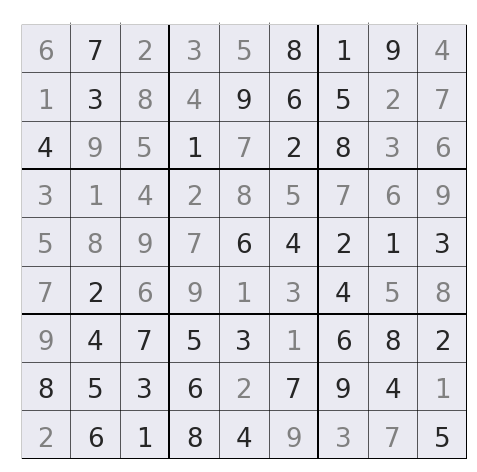

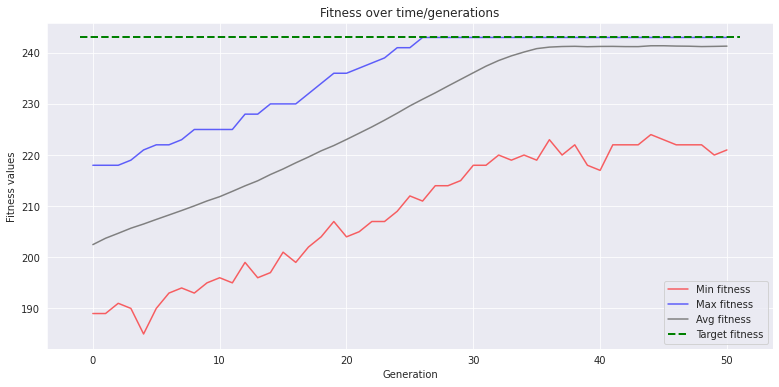

In [18]:
best = hof.items[0]
print(f"Best Solution: {best}")
print(f"Best Score: {best.fitness.values[0]} / 243\n")

draw_board_from_ind(best)
print('')

min_fit_val, max_fit_val, mean_fit_val = logbook.select("min", "max", "avg")

sns.set_style("darkgrid")
plt.figure("Stats:", figsize=(13,6))
plt.plot(min_fit_val, color='red', label='Min fitness', alpha=.6)
plt.plot(max_fit_val, color='blue', label='Max fitness', alpha=.6)
plt.plot(mean_fit_val, color='grey', label='Avg fitness')
plt.xlabel('Generation')
plt.ylabel('Fitness values')
plt.title('Fitness over time/generations')
plt.plot([-1, 51], [243, 243], 'g--', linewidth=2, label='Target fitness')
plt.legend()

plt.show()

După cum se poate observa, algoritmul evolutiv a ajuns să rezolve această problemă într-un număr mai mic de generații decât numărul stabilit inițial. Se poate vedea că acesta a ajuns la soluția optimă în jurul generației 30.

## Algoritmul Hill Climber

Pentru a folosi această metodă, trebuie să modificăm metoda de generare a configurațiilor astfel:

In [19]:
def generate_random_board():
    board = (np.indices((9,9)) + 1)[1]

    for i in range(len(board)):
        board[i] = np.random.permutation(board[i])
    
    for (val, row, col) in BOARD_CONFIG:
        value_index = np.where(board[row]==val)[0][0]
        board[row][value_index], board[row][col] = board[row][col], board[row][value_index]

    return board

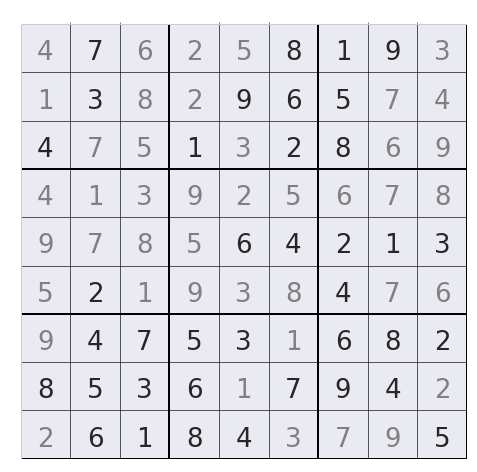

In [20]:
test_b = generate_random_board()
draw_board(test_b)

Se va implementa metoda care caută soluția următoare cea mai optimă.

In [21]:
def best_neighbor(board_state):
    temp_board = board_state.copy()
    best = (0, (0,0), -1)

    board_conf_cords = list(zip(BOARD_CONFIG.T[1], BOARD_CONFIG.T[2]))

    for i in range(len(temp_board)):
        for j in range(len(temp_board[i])):
            for k in range(i,len(temp_board)):
                if ((i, j) in board_conf_cords) or ((i, k) in board_conf_cords):
                    continue
                temp_board[i][j], temp_board[i][k] = temp_board[i][k], temp_board[i][j]

                contestant = (i, (j,k), board_fitness(temp_board))

                if(contestant[2] > best[2]):
                    best = contestant

                temp_board[i][j], temp_board[i][k] = temp_board[i][k], temp_board[i][j]
    return best

După cum se observă, metoda găsește o soluție mai bună (nu perfectă). Acest lucru înseamnă tendința metodei de a porni spre "deal" (hill climber).

In [22]:
print(board_fitness(test_b))
print(best_neighbor(test_b))

209
(0, (0, 3), 212)


După aceste modificări/implementări, se construiește metoda principală `hill_climber` care conține elementele principale ale acesei metode.

In [23]:
def hill_climber(board_state):
    scores = []
    maxScore = board_fitness(board_state)
    # print("Initial score: " + str(maxScore))
    while True:
        # print("Current score: " + str(maxScore))
        scores.append(maxScore)
        (row, (col1, col2), nextScore) = best_neighbor(board_state)
        if(nextScore <= maxScore):
            return scores

        board_state[row][col1], board_state[row][col2] = board_state[row][col2], board_state[row][col1]
        maxScore = nextScore

Urmează secvența de rulare a algoritmului, descris prin următoarea secvență de cod. De sigur, se va seta numărul de încercări ale acestuia.

In [24]:
NR_CLIMBER = 1000

Try 0: max_fitness[ 227 ], fitness[ 227 ]
Try 1: max_fitness[ 227 ], fitness[ 225 ]
Try 2: max_fitness[ 228 ], fitness[ 228 ]
Try 3: max_fitness[ 228 ], fitness[ 222 ]
Try 4: max_fitness[ 228 ], fitness[ 227 ]
Try 5: max_fitness[ 228 ], fitness[ 228 ]
Try 6: max_fitness[ 228 ], fitness[ 227 ]
Try 7: max_fitness[ 228 ], fitness[ 226 ]
Try 8: max_fitness[ 232 ], fitness[ 232 ]
Try 9: max_fitness[ 232 ], fitness[ 232 ]
Try 10: max_fitness[ 232 ], fitness[ 223 ]
Try 11: max_fitness[ 232 ], fitness[ 223 ]
Try 12: max_fitness[ 232 ], fitness[ 224 ]
Try 13: max_fitness[ 234 ], fitness[ 234 ]
Try 14: max_fitness[ 234 ], fitness[ 231 ]
Try 15: max_fitness[ 234 ], fitness[ 225 ]
Try 16: max_fitness[ 234 ], fitness[ 234 ]
Try 17: max_fitness[ 234 ], fitness[ 226 ]
Try 18: max_fitness[ 234 ], fitness[ 230 ]
Try 19: max_fitness[ 234 ], fitness[ 230 ]
Try 20: max_fitness[ 234 ], fitness[ 230 ]
Try 21: max_fitness[ 234 ], fitness[ 229 ]
Try 22: max_fitness[ 234 ], fitness[ 228 ]
Try 23: max_fitness[ 

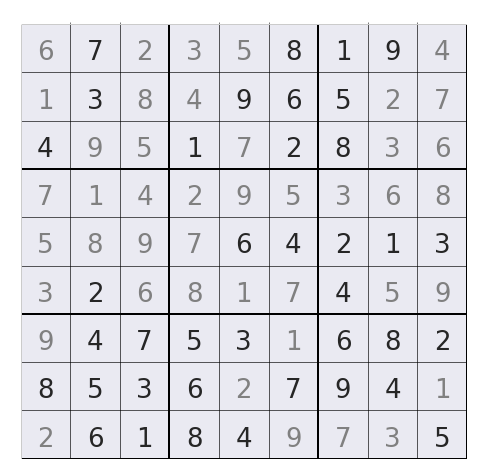

In [25]:
trials = []
max_score = -1
best_board = []

for i in range(NR_CLIMBER):
    board = generate_random_board()
    final_score = hill_climber(board)
 
    max_final_score = max(final_score)
 
    if(max_score < max_final_score):
        max_score = max_final_score
        best_board = board.copy()
  
    print(f'Try {i}: max_fitness[ {max_score} ], fitness[ {final_score[-1]} ]')
 
    if(final_score == 243):
        print("Solution Found")
        draw_board(board)
        break
    trials.append(final_score)
    # print(finalScore)
print(f"The best solution fitness: {max_score}")
draw_board(best_board)

După cum se poate observa, nu prea ajung agenți metodei la soluția optimă

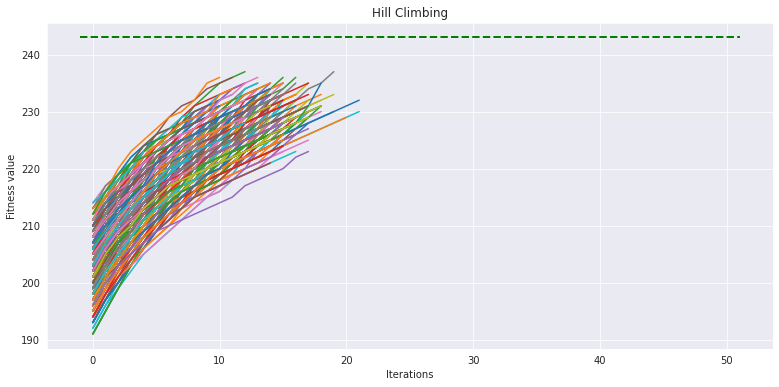

In [26]:
sns.set_style("darkgrid")
plt.figure("Stats:", figsize=(13,6))
for trial in trials:
	plt.plot(trial)
plt.title('Hill Climbing')
plt.ylabel('Fitness value')
plt.xlabel('Iterations')
plt.plot([-1, 51], [243, 243], 'g--', linewidth=2, label='Target fitness')
plt.show()

# Experimente și rezultate

Pentru această parte se vor compara rezultatele obținute din cele două metode.

Prima metodă a rulat 2 minute și 54 de secunde, comparativ cu cealaltă metodă care a rulat mult mai mult. Totodată prima metodă a obținut soluția optimă pentru problema propusă.

<img src="https://raw.githubusercontent.com/jafetimbre/fantastic-sudoku-solver/master/img/simplevoalg_result.png" width="800">

Fig. 3. Rezultatele metodei bazate pe algoritmul evolutiv [Sursa imaginii](https://raw.githubusercontent.com/jafetimbre/fantastic-sudoku-solver/master/img/simplevoalg_result.png)

După cum se observă metoda bazată pe algoritmul eolutiv a ajuns la soluția optimă în aproximativ 30 de generații folosind parametrii propuși inițial. Media valorilor de fitnes a avut o convergență uniformă, după cum se poate vedea și din graficul anterior.

<img src="https://raw.githubusercontent.com/jafetimbre/fantastic-sudoku-solver/master/img/hillclimber_results.png" width="800">

Fig. 4. Rezultatele metodei bazate pe hill climber [Sursa imaginii](https://raw.githubusercontent.com/jafetimbre/fantastic-sudoku-solver/master/img/hillclimber_results.png)

Cu toate că metoda de optimizare bazată pe algoritmul Hill Climber a avut un timp de execuție mult peste timpul de execuție al primei metode, acesta nu a reușit să găsească soluția optimă globală.


# Concluzii

Din acest studiu reiese faptul că algoritmul evolutiv folosit este superior tehnicii de optimizare Hill Climber pentru problema curentă, cu condițiile curente. De sigur, pentru a afirma acest lucru generalizat, trebuie efectuate numeroase coparații și experimente pe diferite probleme de optimizare.

Totodată este foarte importantă natura problemei pentru alegerea tehnicii pe care o vom folosi. 

# Referințe

[Wikipedia](https://ro.wikipedia.org/wiki/Sudoku)

[Sato, Yuji and Inoue, Hazuki: Solving Sudoku with genetic operations that preserve building blocks](https://www.researchgate.net/publication/224180108_Solving_Sudoku_with_genetic_operations_that_preserve_building_blocks)

[Mantere, Timo and Koljonen, Janne: Solving, rating and generating Sudoku puzzles with GA](https://www.researchgate.net/publication/224301656_Solving_rating_and_generating_Sudoku_puzzles_with_GA)

[New Developments in Artificial Intelligence and the Semantic Web](https://seco.cs.aalto.fi/publications/2006/hyvonen-et-al-developments-in-artificial-intelligence-and-the-semantic-web-step-2006.pdf#page=91)
